In [1]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim


2024-08-06 10:59:33.254140: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 10:59:33.254281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 10:59:33.395321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
with open("/kaggle/input/nlp-1221/features.pkl", 'rb') as f:
    features = pickle.load(f)
with open("/kaggle/input/flickr30k/captions.txt", 'r') as f:
    next(f)
    captions_doc = f.read()
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/158916 [00:00<?, ?it/s]

In [3]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption
clean(mapping)

In [4]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

In [ ]:
vocab_size
#vocab_size=18319

In [5]:
image_ids = list(mapping.keys())
print(len(image_ids))
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

31783


In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class ImageCaptionDataset(Dataset):
    def __init__(self, data_keys, mapping, features, tokenizer, max_length, vocab_size):
        self.data_keys = data_keys
        self.mapping = mapping
        self.features = features
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.vocab_size = vocab_size
        
    
    def data(self,index):
        key=self.data_keys[index]
        X1, X2, y = list(), list(), list()
        
        captions = self.mapping[key]
        for caption in captions:
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            seq=pad_sequences([seq], maxlen=self.max_length,padding='post', truncating='post',)[0]
            #padding='post', truncating='post',
            
            X1.append(torch.tensor(self.features[key][0], dtype=torch.float32))
            X2.append(torch.tensor(seq[:-1],  dtype=torch.int64))
            y.append(torch.tensor(seq[1:], dtype=torch.int64))
        return X1, X2, y
    
    def __len__(self):
        return len(self.data_keys)
    
    def __getitem__(self, index):
        X1, X2, y = self.data(index)
        return torch.stack(X1 ), torch.stack(X2, ), torch.stack(y )

In [ ]:

dataset=ImageCaptionDataset(train, mapping, features, tokenizer, 21, vocab_size)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 迭代DataLoader
for batch in dataloader:
    X1, X2, y = batch
    #print(X2)
    #print(y)
    print(X1.shape, X2.shape, y.shape)
    break


In [7]:
class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """

    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn



class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)
class Self_Attention(MultiHeadedAttention):
    def __init__(self,h, d_model, dropout=0.1):
        super().__init__(h, d_model, dropout=0.1)
    def forward(self,x,mask=None):

        out=super().forward(x,x,x,mask)
        return out
class Mlp(nn.Module):
    """
    MLP as used in Vision Transformer, MLP-Mixer and related networks
    """

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.1):
        super().__init__()
        out_features = out_features or in_features  # 768
        hidden_features = hidden_features or in_features  # 3072
        self.fc1 = nn.Linear(in_features, hidden_features)  # 768 --> 3072
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)  # 3072 --> 768
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x



class Block(nn.Module):
    def __init__(self,dim=256,head=8,atten_drop=0.1,in_features=256, hidden_features=512, out_features=256, act_layer=nn.GELU, mlp_drop=0.1,drop=0.1):
        super(Block, self).__init__()
        self.mlp=Mlp(in_features,hidden_features,out_features,act_layer,mlp_drop)
        self.muilt_head=Self_Attention(head,dim,atten_drop)
        self.norm=nn.LayerNorm(dim)
        self.dropout=nn.Dropout(drop)
        self.Mutil_atten=nn.Sequential(
            self.norm,
            self.muilt_head,
            self.dropout
        )
        self.Mlp_layer=nn.Sequential(
            self.norm,
            self.mlp,
            self.dropout
        )

    def forward(self,x):

        x1=self.Mutil_atten(x)+x
        x2=self.Mlp_layer(x1)+x1
        return x2

class PositionalEmbedding(nn.Module):

    def __init__(self, d_model, max_len=35):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

class BERTEmbedding(nn.Module):


    def __init__(self, vocab_size, embed_dim,max_len, dropout=0.1):

        super().__init__()
        self.token = nn.Embedding(vocab_size,embed_dim)
        self.position = PositionalEmbedding(embed_dim,max_len)

        self.dropout = nn.Dropout(p=dropout)
        self.embed_dim = embed_dim

    def forward(self, sequence):
        x = self.token(sequence) + self.position(sequence)
        return self.dropout(x)

class Cross_Block(nn.Module):
    def __init__(self,dim=256,head=8,vis_dim=4096,max_len=20,atten_drop=0.1,in_features=256, hidden_features=512, out_features=256, act_layer=nn.GELU, mlp_drop=0.1,drop=0.1):
        super(Cross_Block, self).__init__()

        self.mlp=Mlp(in_features,hidden_features,out_features,act_layer,mlp_drop)
        self.muilt_head=Self_Attention(head,dim,atten_drop)
        self.norm=nn.LayerNorm(dim)
        self.dropout=nn.Dropout(drop)
        self.linear_cross=nn.Linear(vis_dim,dim*max_len)
        self.cross_atten=MultiHeadedAttention(head,dim,atten_drop)
        self.Mlp_layer=nn.Sequential(
            self.norm,
            self.mlp,
            self.dropout
        )

    def forward(self,x,vis_x,mask=None):
        B,C,N=x.shape
        x1=self.norm(x)
        x1=self.muilt_head(x1,mask)
        x1=self.dropout(x1)+x

        x2=self.norm(x1)
        vis_x=self.linear_cross(vis_x).reshape(B,C,N)
        x2=self.cross_atten(x2,vis_x,vis_x)
        x2=self.dropout(x2)+x1

        x3=self.Mlp_layer(x2)+x2
        return x3


In [8]:
class Encoder(nn.Module):
    def __init__(self,config):
        super(Encoder, self).__init__()
        #self.pos_emb=BERTEmbedding(config.vocab_size, config.dim,config.max_len, config.dropout)
        #self.block=Block(config.dim,config.head,config.atten_drop,config.in_features, config.hidden_features,
        #                 config.out_features, config.act_layer, config.mlp_drop,config.drop)
        self.blocks = nn.Sequential(*[
            Block(config.dim, config.head, config.atten_drop, config.in_features, config.hidden_features,
                  config.out_features, config.act_layer, config.mlp_drop, config.drop)
            for i in range(config.encoder_depth)
        ])
        self.itc_mlp=Mlp(config.max_len*config.dim,config.vison_emb*2,config.vison_emb,)
    def forward(self,x):
        #x=self.pos_emb(x)
        x=self.blocks(x)
        B,S,N=x.shape
        x=x.reshape(B,-1)
        x=self.itc_mlp(x)
        return x

class Decoder(nn.Module):
    def __init__(self,config):
        super(Decoder, self).__init__()
          #self.block=Block(config.dim,config.head,config.atten_drop,config.in_features, config.hidden_features,
        #                 config.out_features, config.act_layer, config.mlp_drop,config.drop)

        #dim = 256, head = 8, vis_dim = 4096, max_len = 20, atten_drop = 0.1,
        #in_features = 256, hidden_features = 512,out_features = 256, act_layer = nn.GELU,\
        #mlp_drop = 0.1, drop = 0.1
        self.blocks = nn.ModuleList([
            Cross_Block(config.dim, config.head,config.vison_emb,config.max_len, config.atten_drop, config.in_features, config.hidden_features,
                  config.out_features, config.act_layer, config.mlp_drop, config.drop)
            for i in range(config.encoder_depth)
        ])

        self.proj=Mlp(config.dim,config.dim*2,config.vocab_size)
        self.mask=torch.tril(torch.ones(config.max_len, config.max_len)).expand(1, 1, config.max_len, config.max_len)
        self.softmax=nn.LogSoftmax(dim=-1)
    def forward(self,x,vis_x):
        #x=self.pos_emb(x)
        device = x.device
        self.mask = self.mask.to(device)
        for block in self.blocks:
            x=block(x,vis_x,self.mask)


        B,S,N=x.shape

        x=self.proj(x)
        x=self.softmax(x)
        return x
class Encoder_Decoder(nn.Module):
    def __init__(self,config):
        super(Encoder_Decoder, self).__init__()
        self.pos_emb = BERTEmbedding(config.vocab_size, config.dim, config.max_len, config.dropout)
        self.encoder=Encoder(config.Encoder)
        self.decoder=Decoder(config.Decoder)
    def forward_itc_loss(self,x):
        x=self.pos_emb(x)
        out=self.encoder.forward(x)
        return out
    def forward(self,x,vis_x):
        x=self.pos_emb(x)
        out=self.decoder.forward(x,vis_x)
        return out
   

In [ ]:
def itc_loss(image_embeds, text_embeds, temperature=0.1):
    # 计算相似度矩阵
    sim_matrix = torch.matmul(image_embeds, text_embeds.T) / temperature
    
    # 从图像到文本的对比损失
    sim_i2t = F.log_softmax(sim_matrix, dim=1)
    loss_i2t = -torch.diag(sim_i2t).mean()
    
    # 从文本到图像的对比损失
    sim_t2i = F.log_softmax(sim_matrix.T, dim=1)
    loss_t2i = -torch.diag(sim_t2i).mean()
    
    # 总对比损失
    itc_total_loss = (loss_i2t + loss_t2i) / 2
    
    return itc_total_loss

In [9]:
class Config:
    vocab_size = 18319
    dim = 256
    dropout = 0.1
    max_len = 20
    class Encoder:
        dim = 256
        head = 8
        atten_drop = 0.1
        in_features = 256
        hidden_features = 512
        out_features = 256
        act_layer = nn.GELU
        mlp_drop = 0.1
        drop = 0.1
        vocab_size=18319
        encoder_depth=4
        dropout = 0.1
        max_len=20
        vison_emb=4096
    class Decoder:
        dim = 256
        head = 8
        atten_drop = 0.1
        in_features = 256
        hidden_features = 512
        out_features = 256
        act_layer = nn.GELU
        mlp_drop = 0.1
        drop = 0.1
        vocab_size =18319
        encoder_depth = 10
        dropout = 0.1
        max_len = 20
        vison_emb = 4096

In [ ]:
"""
config=Config
device="cuda"
model=Encoder_Decoder(config)
resume=True
if resume==True:
    model.load_state_dict(torch.load('/kaggle/input/cnn-transformer/model_weights.pth'),strict=False)
"""

In [ ]:
"""
del(model)
"""

In [ ]:


config=Config
device="cuda"
model=Encoder_Decoder(config)
resume=True
if resume==True:
    model.load_state_dict(torch.load('/kaggle/working/E_D_weights.pth'))

model.to(device)
model.train()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00000001)

dataset=ImageCaptionDataset(train, mapping, features, tokenizer, config.max_len+1, vocab_size)
dataloader = DataLoader(dataset, batch_size=12, shuffle=True)


tt=[]
for epoch in range(20):
    phar=tqdm(total=len(dataloader))
    avg_loss=0
    for i,data in enumerate(dataloader):
        x1,x2,target=data
        B,N,C=x1.shape
        x1=x1.reshape(B*N,-1).to(device)# vision
        x2=x2.reshape(B*N,-1).to(device)# word
        target=target.reshape(B*N,-1).to(device)# word equal x2
        
        B,N=target.shape
        
        y=model(x2,x1)
        
        
        
        #print(y.shape)
        #print(x1.shape)
        y=y.reshape(B*N,-1)
        target=target.reshape(B*N,-1).squeeze(1)
        #print(y.shape)
        #print(target.shape)
        
        loss=criterion(y,target)

        avg_loss=avg_loss+loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(i%200==1):
            #print(loss)
            print(avg_loss/(i+1))
            #print(i)
            #print(avg_loss)
            #print(y[0,:20])
            #print(target)
           
            tt.append(loss.detach().cpu())
        phar.update()
    torch.save(model.state_dict(), 'E_D_weights.pth')
    print("all_average_loss:")
    print(avg_loss/(i+1))
    phar.close()

In [ ]:
del(model)

In [ ]:
config=Config
device="cuda"
model=Encoder_Decoder(config)
resume=True
if resume==True:
    model.load_state_dict(torch.load('/kaggle/input/cnn-transformer/E_D_weights.pth'))
model.to(device)

In [ ]:
model

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    image=torch.tensor(image,dtype=torch.float32)
    image=image.unsqueeze(0).to(device)
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length,padding='post', truncating='post')
        # predict next word
        sequence=torch.tensor(sequence,dtype=torch.int32).to(device)
        #print(sequence.shape)
       
        yhat = model(sequence,image)
        yhat=yhat[:,i,:]
        #print(yhat.shape)
        # get index with high probability
        yhat = torch.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text




In [ ]:
key="1000366164"
y_pred = predict_caption(model, features[key], tokenizer, 20)
print(y_pred)

---------------------Actual---------------------
startseq caucasian man wearing short-sleeved black shirt and dark-skinned woman wearing sleeveless dress are working at conveyor endseq
--------------------Predicted--------------------
startseq woman in black dress is sorting some candles at conveyor counter endseq
startseq woman in tank top and black pants stands in front of display table endseq
startseq man works at desk with drinks in the background endseq
startseq woman in headscarf is sorting an item endseq
startseq woman is sorting some items at counter with candles endseq


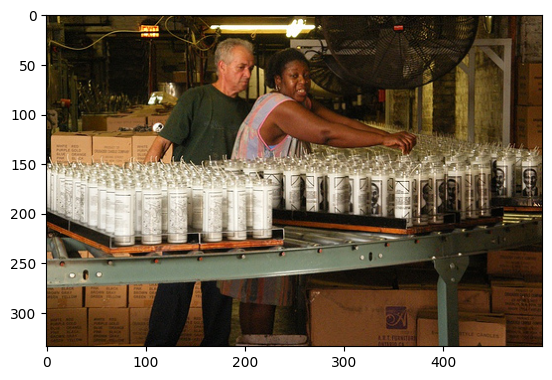

In [31]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR,  image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
        break
    # predict the caption
    
    
    
    print('--------------------Predicted--------------------')
    for k in range(5):
        y_pred = predict_caption(model, features[image_id], tokenizer, 20)
        print(y_pred)

    plt.imshow(image)
BASE_DIR="/kaggle/input/flickr30k/flickr30k_images"
image_name="1010087623.jpg"
generate_caption(image_name)

In [34]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(train[:10]):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, 20)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/10 [00:00<?, ?it/s]

BLEU-1: 0.682927
BLEU-2: 0.532963
